<a href="https://colab.research.google.com/github/dasgupsa/CatsAndDogs/blob/master/CNN_Cats%26Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Convolution Neural Networks: Cats & Dogs

### Introduction

Convolution Neural Networks (CNN) is a growing area and is slowly but steadily starting to make a meaningful impact on our society today. I have tried to study CNN by myself and implemented a small project to crystallise my knowledge. I have chosen a Kaggle competition - [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/overview)  to practice and learn more about CNN.






### Problem Statement

CNN is a algorithm primarily used for image recognition. Kaggle provides a training set which contains 25,000 images of dogs and cats (12,500 of each). Due to the size of the images and Google Drive space, fewer images were taken. For cats and dogs respectively, 3000 images were taken for training, 500 images for validation and 500 images for testing. In total, 8000 images were chosen for analysis.


### Roadmap

Every deep learning project has 4 main steps:

- **Data Collection**: obtaining the data.
- **Preprocessing Data**: preprocessing the images to convert them into the right format for the deep learning models. 
- **Model Building & Results**: building and tuning the models to maximise its performance.
- **Further Steps**: Assessing the results from the algorithms and deciding future steps. Are the results satisfactory and conclusive? Do we need to collect more data / tune exisiting models / search / develop other models to get a better result?

### A Very Brief Explanation of the CNN Process

A computer views an image as a square of numbers (pixels), with a number of channels. The image can have 1 channel (Black and white) or if its a colour image, it will have three channels (RGB - Red Green Blue).
If we feed a black and white image (e.g. 5x5 array of pixels) as an input to the CNN network, the following happens (please look at the [image](https://commons.wikimedia.org/wiki/File:Typical_cnn.png) to understand more clearly):

- [Convolution](http://colah.github.io/posts/2014-07-Understanding-Convolutions/?source=post_page---------------------------): 
We have an image represented as a 5x5 matrix of values, and take a 3x3 filter and slide that 3x3 filter around the image. At each position of that matrix, you multiply the values of your 3x3 filter by the values in the image that are currently being covered by the window. As a result, you'll get a single number that represents all the values in that window of the image. We slide the filter all around the image, starting from the top left and sliding along one step at a time. We have a new matrix with all the "calculated numbers", which will be smaller (due to the multiplication effect) than the original 5x5 image.
- Subsampling: The objective of subsampling is to reduce the dimensions of the calculated matrix to reduce overfitting. One popular subsampling technique  is max pooling. If I have a max-pooling matrix of size 2 x 2, this will slide all over the "reduced matrix" and select the maximum pixel value from the covered 2 x 2 region. This will decrease the size of the "reduced" matrix from above.
- Fully connected layer: The matrix from above is flattened and passed to the output layer to predict the class label.

This [article](http://cs231n.github.io/convolutional-networks/) explains the above in much more depth and more clearly!







### Import Libraries

In [0]:
#General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Machine Learning Libraries
from sklearn.model_selection import train_test_split

# Deep Learning Libraries - using Keras
import keras
from keras.preprocessing import sequence, text
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.sequence import pad_sequences

from keras import layers, models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Embedding, LSTM, Lambda, Conv2D, MaxPooling2D
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
import keras.backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.optimizers import Adadelta, Adam, RMSprop
from keras.utils import np_utils


# CNN Architectures inbuilt in Keras with weights trained on Imagenet

from keras.applications import VGG16, VGG19
from keras.applications import ResNet50
from keras.applications import inception_v3, inception_resnet_v2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet

Using TensorFlow backend.


### Data Collection: Load data from Google Drive

In [0]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

# Folders in google drive which need to be accessed for analysis
import os
#Main Folders
base_dir = "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
#Cats Folders
cats_train_dir =  "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN/train/cats"
cats_validation_dir =  "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN/validation/cats"
cats_test_dir =  "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN/test/cats"
# Dogs Folders
dogs_train_dir =  "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN/train/dogs"
dogs_validation_dir =  "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN/validation/dogs"
dogs_test_dir =  "/content/gdrive/My Drive/mydata/cats_and_dogs_CNN/test/dogs"



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Preprocessing Data

- The images are all in JPEG format, which need to be formatted into floating-point tensors before using them in the CNN network.
-  We convert them to RGB (Red Green Blue) grids of pixels. After that we convert them into floating-point tensors.
- The pixel values are in the range of 0-255 and need to be rescaled to be between 0-1 to help with neural network training.

In [0]:
# We use the Keras function ImageDataGenerator to turn image files into preprocessed tensors

img_rows, img_cols = 128, 128 # resizing all images to  (any appropriate size is fine)
batch_size_for_conversion = 300   # number of samples in a batch to convert

# Rescale images to between 0 and 1
train_data_without_Aug = ImageDataGenerator(rescale=1./255) # training data WITHOUT data augmentation


# Data Augmentation techniques
# Generating more training data from existing training samples, by augmenting the 
# samples via a number of random transformations. 
# This helps expose the model to more aspects of the data and generalize better.
# In Keras, we do Data Augmentation by configuring a number of random transformations to
# be performed on the images read by the ImageDataGenerator instance.


# training data WITH data augmentation
train_data_with_Aug = ImageDataGenerator(rescale=1./255,rotation_range=50,
                             width_shift_range=0.3,height_shift_range=0.3,shear_range=0.3,
                                         zoom_range=0.3,horizontal_flip=True,fill_mode='nearest')


#Validation and Test data are never augmented
validation_data = ImageDataGenerator(rescale=1./255) # validation data
test_data = ImageDataGenerator(rescale=1./255) # test data


train_generator = train_data_without_Aug.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols), 
                                                    batch_size=batch_size_for_conversion,
                                                    class_mode='binary')

train_generator_with_Aug = train_data_with_Aug.flow_from_directory(train_dir,
                                                    target_size=(img_rows, img_cols), 
                                                    batch_size=batch_size_for_conversion,
                                                    class_mode='binary')

validation_generator = validation_data.flow_from_directory(validation_dir,
                                                        target_size=(img_rows, img_cols),
                                                        batch_size=batch_size_for_conversion,
                                                        class_mode='binary')

test_generator = test_data.flow_from_directory(test_dir,
                                                  target_size=(img_rows, img_cols),
                                                  batch_size=batch_size_for_conversion,
                                                  class_mode='binary')

Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Personal CNN Architecture

I built my own custom made CNN architecture to understand the different steps needed. There are 4 steps to building and fitting a CNN model:

- Build the model architecture.
- Compile the model (Loss function, [Optimiser](https://keras.io/optimizers/) and Classification metric).
- Fit the model on the training data (training data, batch size and number of epochs).
- Evaluate the model performance on the test data.

Hyperparameters which can be experimented when building CNN architectures:
 - Number and size of filters
 - Stride
 - Padding
 - Activation 
 - [Dropout](https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5)
 - [Batch Normalisation](http://mlexplained.com/2018/01/10/an-intuitive-explanation-of-why-batch-normalization-really-works-normalization-in-deep-learning-part-1/)


In [0]:
# Function for plotting graphs. Input is dictionary of Neural Network training data 
# (accuracy and loss)
def plotGraphs(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [0]:
#Parameters for all CNN architectures
batch_size = 128
epochs = 50
filter_size=3
droprate=0.3

img_rows, img_cols = 128, 128
RGBSize = 3
input_shape = (img_rows, img_cols, RGBSize)

# For pre-trained networks only
pre_trained_epochs = 50

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_125 (Conv2D)          (None, 126, 126, 64)      1792      
_________________________________________________________________
batch_normalization_106 (Bat (None, 126, 126, 64)      256       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 61, 61, 64)        36928     
_________________________________________________________________
batch_normalization_107 (Bat (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 30, 64)        0         
__________

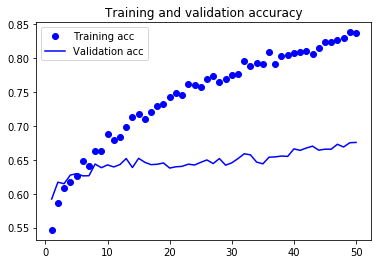

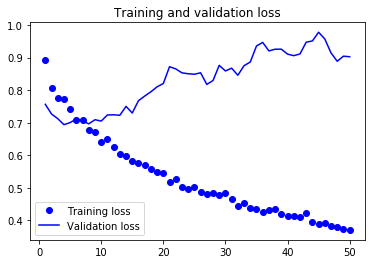

In [0]:


# Model building - using Sequential method as opposed to Functional API
model = models.Sequential()
#Conv Layer 1
model.add(layers.Conv2D(64, (filter_size, filter_size), activation='relu',input_shape=input_shape))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(droprate))

#Conv Layer 2
model.add(layers.Conv2D(64, (filter_size, filter_size), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(droprate))

#Conv Layer 3
model.add(layers.Conv2D(128, (filter_size, filter_size), activation='relu'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(droprate))

#Flatten
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(layers.Dense(1, activation='sigmoid'))
#Summary
model.summary()


#Compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5),metrics=['acc'])



# Fit the model
history = model.fit_generator(
train_generator,steps_per_epoch=20,epochs=epochs,validation_data=validation_generator,
validation_steps=50, verbose=1)

# Plot the graphs
plotGraphs(history)

In [0]:
# Test Set Evaluation
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test accuracy:', test_acc)
print('Test Loss:', test_loss)

Test accuracy: 0.6470967771545533
Test Loss: 0.9613693260377453


Epoch 1/50
20/20 [==============================] - 92s 5s/step - loss: 0.7956 - acc: 0.6303 - val_loss: 0.8389 - val_acc: 0.6936
Epoch 2/50
20/20 [==============================] - 71s 4s/step - loss: 0.7540 - acc: 0.6403 - val_loss: 0.8169 - val_acc: 0.6933
Epoch 3/50
20/20 [==============================] - 71s 4s/step - loss: 0.7644 - acc: 0.6315 - val_loss: 0.7917 - val_acc: 0.6947
Epoch 4/50
20/20 [==============================] - 71s 4s/step - loss: 0.7406 - acc: 0.6425 - val_loss: 0.7593 - val_acc: 0.7000
Epoch 5/50
20/20 [==============================] - 71s 4s/step - loss: 0.7450 - acc: 0.6313 - val_loss: 0.7415 - val_acc: 0.7042
Epoch 6/50
20/20 [==============================] - 71s 4s/step - loss: 0.7356 - acc: 0.6388 - val_loss: 0.7218 - val_acc: 0.7075
Epoch 7/50
20/20 [==============================] - 71s 4s/step - loss: 0.7303 - acc: 0.6385 - val_loss: 0.6921 - val_acc: 0.7217
Epoch 8/50
20/20 [==============================] - 71s 4s/step - loss: 0.7231 - acc: 0.64

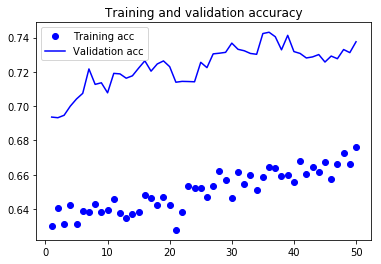

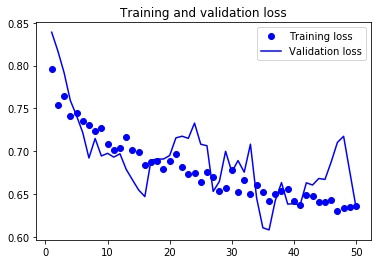

Test accuracy: 0.7232258089127079
Test Loss: 0.6452234954603256


In [0]:
#With Data Augmentation

# Fit the model
history_with_Aug = model.fit_generator(
train_generator_with_Aug,steps_per_epoch=20,epochs=epochs,validation_data=validation_generator,
validation_steps=50, verbose=1)

# Plot the graphs
plotGraphs(history_with_Aug)

# Test Set Evaluation
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test accuracy:', test_acc)
print('Test Loss:', test_loss)

From the above results, data augmentation leads to a better test accuracy of 72% vs 65%.

### Major CNN Architectures

The above is a simple CNN architecture which I came up with. There has been a lot of work done to improve CNN architectures and a list of the popular ones are mentioned below: 

 - [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf):
This is considered to be the first major breakthrough in CNN work used for handwritten character recognition.

 - [AlexNet (2012)](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf): The paper which is often given the credit for the explosion of CNN work. AlexNet was designed by Alex Krizhevsky, Geoffrey Hinton, and Ilya Sutskever. 
 
- [GoogleNet/Inception](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf): It is a 22 layer CNN and was the winner of ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2014 with a top 5 error rate of 6.7%. It set new standards as its architecture was unconvential,  unique and non-sequential. 

- [VGGNet](https://arxiv.org/pdf/1409.1556v6.pdf): It was the  runner-up at the ILSVRC 2014 competition and was very popular in the CNN community.


- [ResNet](https://arxiv.org/abs/1512.03385): It is a 152 layer network architecture that set new records in classification and won ILSVRC 2015 with an error rate of 3.6%.



The above are the key CNN architectures. There are many more including MobileNet, DenseNet and Squeezenet to mention a few. This is an area of active research and we will definitely see more breakthroughs in the years to come.

Many of the these architectures have been coded up in [Keras](https://keras.io/) with weights trained on ImageNet. Please check this [link](https://keras.io/applications/). 

### Pre-trained networks

A pretrained network is a network that has already been 
trained on a large dataset. In Keras, we have [pretrained networks](https://keras.io/applications/) which have been trained on the ImageNet dataset
(1 million plus labeled images and 1,000 different classes).

There are two ways to use a pretrained network: Feature Extraction and Fine-Tuning.

#### Feature Extraction

 - Feature extraction consists of using the representations learned by a previous network (e.g. Imagenet) to extract features from a new dataset (Cats and Dogs). This means we use the network weights learned by the model on the previous dataset(Imagenet in this case), as opposed to learning all the weights again.
 
 - CNN architectures have the convolution and max-pooling phase where the initial features are learnt. These layers are flattened and then sent to a neural network where the image is finally classified. 
 
- With a pre-trained network, we keep the convolution and max pooling layer intact (with the weights learnt from Imagenet classification) and just train the neural network section on top of it. This vastly speeds up training time as we have fewer weights to train to classify the Cats and Dogs dataset.

#### Fine-Tuning (will not be done here)

- Fine-tuning is an extension of feature extraction. 
- We not only train the fully connected neural network on top of the convolutional base but also train some of the convolutional layers before the neural network.


#### Modelling

- I will be looking at three inbuilt Keras CNN archictectures, which are VGG16, InceptionV3 and ResNet50.
- They will all follow a similar pattern:
  - Instantiating the respective Keras Built in CNN Architecture but **excluding**  the neural network classifier responsible for giving the final prediction.
  - Adding my own custom built Neural Network classifier on top of the built in convolution base.
  - Compiling the model.
  - Fitting the model, which involves **only** learning the weights of my neural network classifier.


#### [VGG16](https://arxiv.org/pdf/1409.1556.pdf)

- This architecture was the runner up in ILSVRC 2014.
- This CNN architecture was designed to be an improvement over [Alexnet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) (first CNN architecture to come to prominence).
- The key points of this architecture are:
 - Convolution layers of size 3x3 only.
 - Max Pooling Layers of size 2x2 only.
 - Two Fully connected layers at the end to classify the images.
 - In total there are a total of 16 layers. Please see the Keras VGG16 built in CNN architecture below.

- There is another Keras inbuilt model called VGG19, which is 19 layers deep instead of 16. 

In [0]:
# Keras Inbuilt version of VGG16 WITHOUT the final classifier at the top
# I will be adding the final classifier on top and training ONLY this part of the network
conv_base_VGG16 = VGG16(weights='imagenet',include_top=False, input_shape=(img_rows,img_cols,RGBSize))
conv_base_VGG16.trainable = False # make sure not trained
conv_base_VGG16.summary() # Summary of the architecture 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [0]:
# 1.  weights - pretrained weights on which to initialize the model (ImageNet in this case)
# 2. include_top - refers to including (or not) the densely connected classifier on
# top of the network. In Keras, The default, this densely connected classifier corresponds to
# the 1,000 classes from ImageNet. The Cats and Dogs example has only two classes: cat and dog), 
# you don’t need to include it.
# 3. input_shape (optional) - shape of the image tensors that you’ll feed to the network.
# If empty, the network will be able to process inputs of any size.


# Model building
model = models.Sequential()
model.add(conv_base_VGG16)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

#Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc'])

# Fit the model
historyVGG = model.fit_generator(
train_generator_with_Aug,steps_per_epoch=20,epochs= pre_trained_epochs,validation_data=validation_generator,
validation_steps=50, verbose=1)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               1048704   
_________________________________________________________________
batch_normalization_110 (Bat (None, 128)               512       
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_111 (Bat (None, 64)                256       
__________

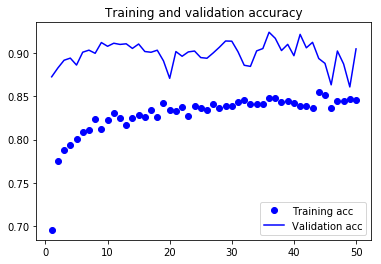

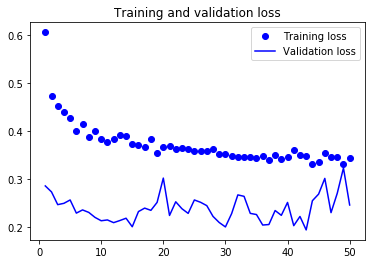

Test accuracy: 0.8657936557890877
Test Loss: 0.30955573053114


In [0]:
# Plot the graphs
plotGraphs(historyVGG)

# Test Set Evaluation
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('Test accuracy:', test_acc)
print('Test Loss:', test_loss)

#### [Inception](https://arxiv.org/abs/1409.4842)

- Winner of the ILSVRC 2014 Competition. 
- Deep CNN architectures can have millions of parameters to train and this can have a significant impact on computing resources.
- The Inception architecture was built to maximise accuracy but also minimising the computational cost by building a "wider" rather than a "deeper" network.
- The Inception deep convolutional architecture was introduced as GoogLeNet in (Szegedy et al. 2015a) - Inception-v1. Later the Inception architecture was refined in various ways, first by the introduction of batch normalization (Ioffe and Szegedy 2015) (Inception-v2). Later by additional factorization ideas in the third iteration (Szegedy et al. 2015b) - Inception-v3.

- [An article](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202) explaining all the different versions and their updates.




In [0]:
# Keras Inbuilt version of InceptionV3 WITHOUT classifier (modelled and trained manually)
conv_base_Incept = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows,img_cols,RGBSize))
conv_base_Incept.trainable = False
conv_base_Incept.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_128 (Conv2D)             (None, 63, 63, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_112 (BatchN (None, 63, 63, 32)   96          conv2d_128[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 63, 63, 32)   0           batch_normalization_112[0][0]    
__________________________________________________________________________________________________
conv2d_129

In [0]:
#Model building
Inceptmodel = Sequential()
Inceptmodel.add(conv_base_Incept)
Inceptmodel.add(layers.Flatten())
Inceptmodel.add(layers.Dense(128, activation='relu'))
Inceptmodel.add(BatchNormalization())
Inceptmodel.add(Dropout(droprate))
Inceptmodel.add(Dense(64, activation='relu'))
Inceptmodel.add(BatchNormalization())
Inceptmodel.add(Dropout(droprate))
Inceptmodel.add(layers.Dense(1, activation='sigmoid'))
Inceptmodel.summary()


#Compile the model
Inceptmodel.compile(loss='binary_crossentropy',
              optimizer= 'adam',
              metrics=['acc'])


#Fit the model
historyInceptionv3 = Inceptmodel.fit_generator(train_generator_with_Aug,steps_per_epoch=20,
epochs=pre_trained_epochs,validation_data=validation_generator,validation_steps=50, verbose=1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               1048704   
_________________________________________________________________
batch_normalization_206 (Bat (None, 128)               512       
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_207 (Bat (None, 64)                256       
__________

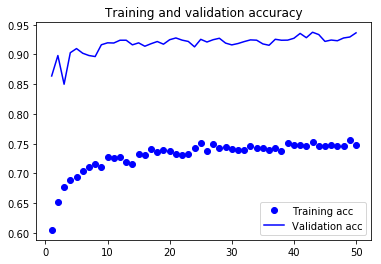

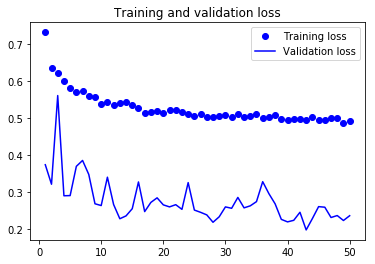

Test Accuracy: 0.9286508006708962
Test Loss: 0.312766931951046


In [0]:
#Plot the graphs
plotGraphs(historyInceptionv3)

# Test Set Evaluation
test_loss, test_acc = Inceptmodel.evaluate_generator(test_generator, steps=50)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

#### [Resnet](https://arxiv.org/abs/1512.03385)

- Won 1st place in the ILSVRC 2015 classification competition with top-5 error rate of 3.57%.
- ResNet's popularity lies in the fact that it enables training of extremely deep neural networks with 152 layers successfully. This was difficult prior to ResNet as training deep networks has the problem of vanishing gradients.
- [An excellent article](https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8) explaining the intuition behind the Resnet architecture.
- Keras has three versions built in Resnet50, Resnet101 and Resnet152. I will be using Resnet50 as it is the smallest network and easiest to train.


In [0]:
# Keras Inbuilt version of Resnet50 WITHOUT classifier. 
res_net_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, RGBSize))
res_net_model.trainable = False
res_net_model.summary()

W0809 20:37:31.792762 140259780286336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 20:37:31.845543 140259780286336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 20:37:31.859467 140259780286336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0809 20:37:31.909260 140259780286336 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0809 20:37:31.910745

94658560/94653016 [==============================] - 4s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
____________________________________________

In [0]:
#Model Building
Resmodel = Sequential()
Resmodel.add(res_net_model)
Resmodel.add(Flatten())
Resmodel.add(Dense(32, activation='relu'))
Resmodel.add(BatchNormalization())
Resmodel.add(Dropout(droprate))
Resmodel.add(Dense(32, activation='relu'))
Resmodel.add(BatchNormalization())
Resmodel.add(Dropout(droprate))
Resmodel.add(Dense(1, activation='sigmoid'))
Resmodel.summary()

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#Compile the model
Resmodel.compile(loss='binary_crossentropy',optimizer= 'adam',metrics=['acc'])

# pre_trained_epochs
# Fit the model
historyResNet = Resmodel.fit_generator(train_generator_with_Aug,steps_per_epoch=20,
epochs=pre_trained_epochs,validation_data=validation_generator,validation_steps=50, verbose=1)



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1048608   
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
__________

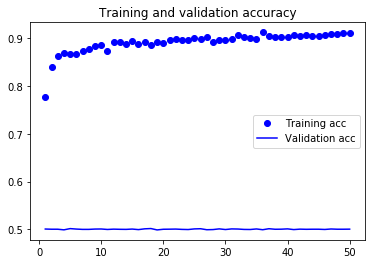

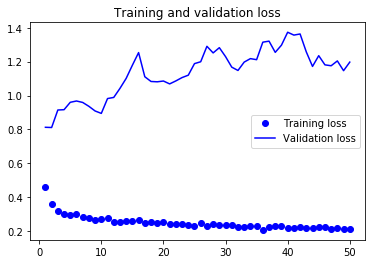

Test Accuracy: 0.5007258028753342
Test Loss: 1.1977448040439236


In [0]:
#Plot the graphs
plotGraphs(historyResNet)

# Test Set Evaluation
test_loss, test_acc = Resmodel.evaluate_generator(test_generator, steps=50)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

### Comparison

The table below shows the performance of all the different classifiers.

In [0]:
# Table created manually.

ResultsData = []
li = []
li.append('CNN WithOut Data Augmentation')
li.append(0.647)
ResultsData.append(li)

li = []
li.append('CNN With Data Augmentation')
li.append(0.723)
ResultsData.append(li)

li = []
li.append('VGG16')
li.append(0.866)
ResultsData.append(li)

li = []
li.append('InceptionV3')
li.append(0.929)
ResultsData.append(li)

li = []
li.append('ResNet50')
li.append(0.501)
ResultsData.append(li)

df_data = pd.DataFrame(ResultsData)
df_data.columns = ["Algorithm", "Test Accuracy"]
df_data

,Algorithm,Test Accuracy
0,CNN WithOut Data Augmentation,0.647
1,CNN With Data Augmentation,0.723
2,VGG16,0.866
3,InceptionV3,0.929
4,ResNet50,0.501


### Conclusion

- From the five different techniques used, InceptionV3 gave the best test accuracy . This was better than my own CNN implementation with data augmentation by 21%.
- This seems like the weights learnt from ImageNet by InceptionV3 are most suitable to this particular dataset (Cats and Dogs).
- Designing a unique CNN architecture which can outperform existing CNN architectures is difficult.
- ResNet50 (50 layers) provided the worst test accuracy at 50.1%. Further hyperparameter tuning is required to improve the accuracy. 
Another option is retraining the entire network from scratch to improve the classification accuracy.

### Further Work

This notebook was written primarily as a learning tool to learn more about CNN.  There is far more that could have been done. Some further work that could be done includes:

- Further hyperparameter tuning of the above architectures to extract the highest accuracy possible.
- Evaluate the effectiveness of the other CNN architectures e.g. MobileNet, DenseNet and Squeezenet to see if they can classify the images more accurately.
- [CNN ensembling techniques](https://towardsdatascience.com/ensembling-convnets-using-keras-237d429157eb) could be tried to improve the classification accuracy.



### References

This is a list of good websites, which I have found very useful:

- [Excellent introductory article to CNN](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)

### Key Terms

There are some terms, which are very common in Machine Learning literature and a brief explanation is provided:

- [Supervised Learning](https://en.wikipedia.org/wiki/Supervised_learning): There are input variables (x) and an output variable (y). We need to find an algorithm to learn the mapping function from the input to the output.
- [Unsupervised Learning](https://en.wikipedia.org/wiki/Unsupervised_learning): There is only input data (x) and no corresponding output variable (y). The aim is to model the underlying structure or distribution in the data in order to learn more about the data.
- [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html): It's a technique where the data is split into several parts. We tune our model on some parts of the data. We test the model's performance on the data which was kept aside. For a detailed explanation, please refer to this [link](https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html)
- [Log Loss (logistic loss/cross-entropy loss)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) - A performance metric used to evaluate the probability outputs of a classifier as opposed to its predictions.
- [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) - A performance measure which determines the percentage of samples the algorithm was able to classify correctly.
- [Perfomance Measures (precision, recall, f1-score) ](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/) - Some other measures which help us determine the quality of the algorithm's perfomance.
- [ROC Curves for Binary Classification](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/) - Receiver Operating Characteristic (ROC) curves are an important classification metric, especially for binary classification. For deep learning models, please check this [link](https://machinelearningmastery.com/how-to-calculate-precision-recall-f1-and-more-for-deep-learning-models/).
